Step 3: Optimization with uncertain conversion rates

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#fixed alphas (same number of users each day distributed equally between the inital webpages)
#uncertain conversion rates

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [2]:
P1 = Product(0,[9,12,13,14.5],[ 1.,  4,  5., 6.5])
P2 = Product(1,[20,22.5,23,24.5],[ 4.,  6.5, 7., 8.5])
P3 = Product(2,[30,31.5,34,34.5],[ 6.,  7.5, 10., 10.5])
P4 = Product(3,[40,42.5,43,46.5],[ 8., 10.5, 11., 14.5])
P5 = Product(4,[50,51.5,53,54.5],[10., 11.5, 13., 14.5])

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])
E.set_products(products)
E.set_lambda(0.5)

Estimation of conversion rates and expected rewards of the arms for each product to compute the clairvoyant solution

In [3]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])  
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i])

    conv_rates_per_experiment.append(conversion_rates)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) + np.std(opt_vector)**2
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i])
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.69104209 0.16156565 0.06685263 0.01236807]
 [0.93261577 0.59702371 0.50366929 0.22837788]
 [0.99325138 0.95918708 0.69403531 0.60424281]
 [0.6919399  0.22857455 0.15814816 0.00316093]
 [0.97732254 0.89458091 0.68946071 0.39718119]]
_______________________________________________
Expected rewards per arm
[[0.69369407 0.56548749 0.28382799 0.06733165]
 [3.71693407 3.37834211 2.91820095 1.60397308]
 [5.95990064 6.38360208 5.75572507 4.96568246]
 [5.58281628 2.11579857 1.47288497 0.0329836 ]
 [9.7792153  9.05931728 7.37724962 4.62210927]]
_______________________________________________
Best configuration [0. 1. 1. 0. 1.]
Optimal cumulative expected reward per round
27.59826637072788


Thompson Sampling: optimization of the cumulative expected margin over all the products

In [18]:

#Thompson Sampling
n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 365
fixed_alpha = 1
fixed_weights = 1
n_experiments = 10

ts_rewards_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights)
    ts_learner = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

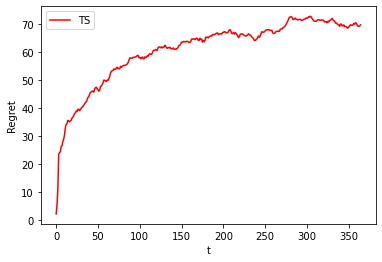

In [19]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

In [20]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation considering 10 experiments
10003.751704450216 17.03304297024905
-----------------------------------------------
Total expected regret over 365 days and its standard deviation considering 10 experiments
69.61552086546016 17.03304297024913
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 10 experiments
27.407538916301963 0.8504532607828666
-----------------------------------------------
Average expected regret per round over 365 days and its standard deviation between the rounds considering 10 experiments
0.1907274544259182 0.8504532607828666


Text(0.5, 1.0, 'Expected regret per round')

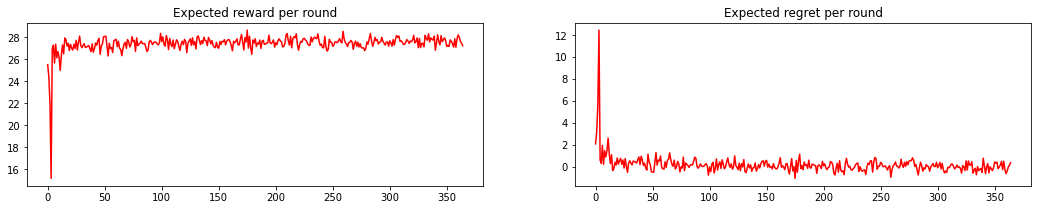

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ts_rewards_per_experiment, axis=0)), 'r')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ts_rewards_per_experiment, axis=0)), 'r')
ax[1].set_title("Expected regret per round")

In [22]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ts_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 0.68393158  0.43437311  0.13905922  0.00774148]
 [ 3.57258786  3.91792234  2.47648168  0.55621597]
 [ 6.          7.10339059  2.98774698  3.8647742 ]
 [ 5.50639008  0.525       0.44        0.        ]
 [10.         10.08908402  6.15408413  1.0875    ]]
_______________________________________________
Pulls per arm for the last experiment
[341, 16, 5, 3]
[5, 335, 23, 2]
[1, 340, 17, 7]
[362, 1, 1, 1]
[2, 354, 8, 1]


UCB: : optimization of the cumulative expected margin over all the products

In [23]:
#UCB

n_arms = 4
num_users = 100
binary_vector = np.array([127,0]) 
n_days = 365
fixed_alpha = 1
fixed_weights = 1
n_experiments = 10

ucb_rewards_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha,fixed_weights)
    ucb_learner = UCB(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


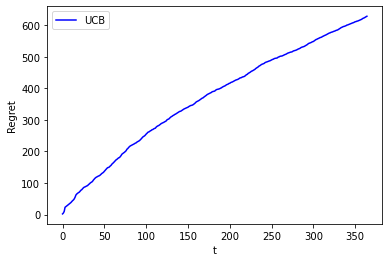

In [24]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["UCB"])
plt.show()

In [25]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation between 10 experiments
9443.992839629169 32.47090589965656
-----------------------------------------------
Total expected regret over 365 days and its standard deviation between 10 experiments
629.3743856865085 32.470905899656614
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 10 experiments
25.873952985285396 1.0340874635534434
-----------------------------------------------
Average expected regret per round over 365 days and its standard deviation between the rounds considering 10 experiments
1.724313385442489 1.034087463553443


Text(0.5, 1.0, 'Expected regret per round')

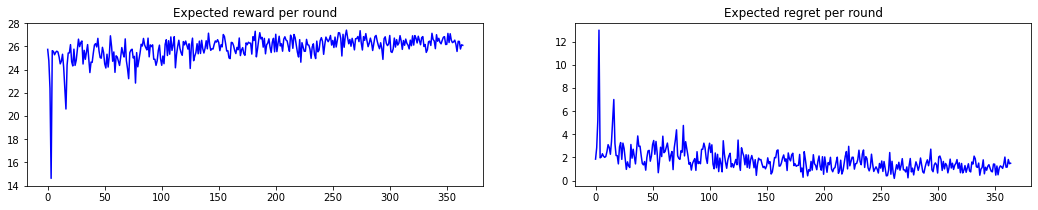

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ucb_rewards_per_experiment, axis=0)), 'b')
ax[1].set_title("Expected regret per round")

In [27]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ucb_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

print("_______________________________________________")
print("Upper confidence bounds for the last experiment")
print(ucb_learner.confidence)

_______________________________________________
Expected rewards per arm for the last experiment
[[0.6957548  0.61616756 0.19274429 0.05930731]
 [3.72560947 3.23702424 2.48648697 0.65039792]
 [5.95026692 6.44618314 3.62148984 3.33930107]
 [5.49810662 1.52458921 1.07808704 0.        ]
 [9.80052173 7.19054756 4.62801167 2.52131148]]
_______________________________________________
Pulls per arm for the last experiment
[232, 108, 15, 10]
[228, 90, 37, 10]
[114, 208, 23, 20]
[330, 15, 12, 8]
[276, 54, 22, 13]
_______________________________________________
Upper confidence bounds for the last experiment
[[0.22552424 0.33046415 0.88568786 1.07437806]
 [0.22749392 0.36183619 0.56459284 1.06680452]
 [0.32172499 0.23812476 0.71525747 0.7621117 ]
 [0.18909509 0.88023792 0.97585286 1.1682878 ]
 [0.20676769 0.46734688 0.726645   0.9375691 ]]


In [28]:
#Theoretical comparison

opt_per_product = np.zeros(5)
delta_arms_per_product = np.zeros((5,4)) #differencees with the mean reward of the optimal arm
upper_bound_regret_per_product = np.zeros(5)
for i in range(5):
    opt_per_product[i] = np.max(margins_matrix[i,:] * conversion_rates[i])
    for j in range(4):
        delta_arms_per_product[i,j] = opt_per_product[i] - ucb_learner.expected_rewards[i,j]
        if delta_arms_per_product[i,j]>0:
            upper_bound_regret_per_product[i] += 4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j]
   

#R(UCB)<SUM(4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j])
print("Upper bound theoretical regret per product")
print(upper_bound_regret_per_product)
print("Ratio between empiric regret and the upper bound")
empiric_regret = np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1))
print(empiric_regret/np.sum(upper_bound_regret_per_product))

Upper bound theoretical regret per product
[14577.29601033   265.54039552   138.37455713   595.32333001
   193.22747704]
Ratio between empiric regret and the upper bound
0.03991020250430893


Greedy Learner: each round chose the current best solution

In [93]:

#Greedy Learner
n_arms = 4

num_users = 100
binary_vector = np.array([127,0]) 
n_days = 365
fixed_alpha = 1
fixed_weights = 1
margins_matrix = np.array([[2.,  5.,  8., 11.], [4.,  7., 10., 13.],[6.,  9., 12., 15.],[ 8., 11., 14., 17],[10., 13., 16., 19.]])

env = Environment(n_arms, E, margins_matrix, num_users, binary_vector, fixed_alpha, fixed_weights)
gr_learner = Greedy(n_arms=n_arms)

for d in range(n_days):
    
    pulled_arm = gr_learner.pull_arm(env.margins_matrix)
    reward = env.round(pulled_arm)
    gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

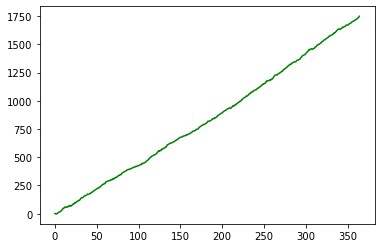

In [94]:
plt.plot(np.cumsum(opt-gr_learner.collected_rewards),'g')